In [1]:
from scipy.ndimage import gaussian_filter
import numpy  as np
import matplotlib.pyplot as plt
import time
from utils import *
import copy
from hcipy import *
import os.path
import csv
from astropy.io import fits
from processing import *
from IPython.lib.display import Audio
import numpy as np

%matplotlib inline

# Import Files

## Input File Names

In [2]:
# Input the filename you want to save as
saved_file_name = "Comparison_Test_Mag_5_Band_V"

# Input the name of the fits files as a list of strings. Used for loading FITS data.
fits_names = ["ProEM_Mag_5_Band_V.fits",
              "iXon897_Mag_5_Band_V.fits",
              "ORCA_Quest_Mag_5_Band_V.fits",
              "Kinetix_Mag_5_Band_V.fits",
              "Prime_BSI_Mag_5_Band_V.fits",
              ] 

# Input the sigma for the contrast curves
sigma = 5 

## Load Fits Files

In [3]:
fits_files = []
for i in fits_names:
    fits_files.append(fits.open(i))

## Load Header Data

In [12]:
wavelengths = []
pupil_diameters = []
mags = []
qs = []
shutters = []
fpss = []
read_noises = []
dark_currents = []
seeings = []
outer_scales = []
velocitys = []
quantum_efficiencys = []
exposure_times = []
exposure_numbers = []
filter_names=[]
EM_gains = []
EM_saturates = []
full_well_depths = []
for i in fits_files:
    wavelength = i[0].header['Wavelnth']
    wavelength = wavelength.split(' ')
    wavelengths.append(float(wavelength[0]))
    pupil_diameter = i[0].header['PUPDIAMT']
    pupil_diameter = pupil_diameter.split(' ')
    pupil_diameters.append(float(pupil_diameter[0]))
    mag = i[0].header['PRIMAG']
    mag = mag.split(' ')
    mags.append(float(mag[0]))
    q = i[0].header['Q']
    q = q.split(' ')
    qs.append(float(q[0]))
    fps = i[0].header['FPS']
    fps = fps.split(' ')
    fpss.append(fps[0])
    read_noise = i[0].header['RdNoise']
    read_noise = read_noise.split(" ")
    read_noises.append(read_noise[0])
    dark_current = i[0].header['DarkCurr']
    dark_current = dark_current.split(" ")
    dark_currents.append(dark_current[0])
    quantum_efficiency = i[0].header['QE']
    quantum_efficiency = quantum_efficiency.split(" ")
    quantum_efficiencys.append(quantum_efficiency[0])
    seeing = i[0].header['Seeing']
    seeing = seeing.split(" ")
    seeings.append(seeing[0])
    outer_scale = i[0].header['OutScale']
    outer_scale = outer_scale.split(' ')
    outer_scales.append(outer_scale[0])
    velocity = i[0].header['Velocity']
    velocity = velocity.split(' ')
    velocitys.append(velocity[0])
    exposure_time = i[0].header['ExpoTime']
    exposure_time = exposure_time.split(" ")
    exposure_times.append(exposure_time[0])
    exposure_number = i[0].header['NumExpos']
    exposure_number = exposure_number.split(" ")
    exposure_numbers.append(exposure_number[0])
    filter_name = i[0].header['FiltName']
    filter_name = filter_name.split(" ")
    filter_names.append(filter_name[0])
    try:
        EM_gain = i[0].header['EMGAIN']
        EM_gain = EM_gain.split(" ")
        EM_gains.append(EM_gain[0])
    except KeyError:
        EM_gains.append("")
    try:
        EM_saturate = i[0].header['EMSAT']
        EM_saturate = EM_saturate.split(" ")
        EM_saturates.append(EM_saturate[0])
    except KeyError:
        EM_saturates.append("")
    try:
        full_well_depth = i[0].header['FullWell']
        full_well_depth = full_well_depth.split(" ")
        full_well_depths.append(full_well_depth[0])
    except KeyError:
        full_well_depths.append("")

# Combine Image Data

In [5]:
ims_out_as = []
for i in fits_files:
    print("Combining Image Data for ", i[0].header['Title'])
    npix = int(np.sqrt(np.prod(i[1].data.shape)))
    ims_out = []
    for j in range(1, len(i)):
        im = i[j].data
        im_out = im.copy().reshape([npix,npix])
        ims_out.append(np.array(im_out))
    ims_out_as.append(np.array(ims_out))
print("Image Combining Complete")

Combining Image Data for  ProEM_Mag_5_Band_V
Combining Image Data for  iXon897_Mag_5_Band_V
Combining Image Data for  ORCA_Quest_Mag_5_Band_V
Combining Image Data for  Kinetix_Mag_5_Band_V
Combining Image Data for  Prime_BSI_Mag_5_Band_V
Image Combining Complete


# Image Processing

In [6]:
## Image Processing
# includes preprocessing, taking FTs, power spectra, and ACFs

# Function Parameters - see processing.py for more detail
# ims           - input image array
# ims_ft        - input FT array
# gsigma        - std deviation for the Gaussian kernel
# subframe_size - final image size in pixels
# HWHM          - half-wavelength at half maximum for supergaussian window
# m             - order of supergaussian window
# scaling       - determines radial cutoff (fcut) for PS
ims_ps=[]
FTs =[]
PSs = []
Av_PSs = []
ACFs = []
ACF_ccs = []
ACF_xaxs = []

for i in range(len(fits_files)):
    print("Processing", fits_files[i][0].header['Title'] )
    print("Performing Image Preprocessing")
    ims_p = image_preprocessing(ims_out_as[i], 10, 550)
    #              parameters: (ims, gsigma, subframe_size)
    ims_ps.append(ims_p)
    print("Taking Fourier Transform")
    FT = fourier_transform(ims_p, 100, 4)
    #              parameters: (ims, HWHM, m)
    FTs.append(FT)
    print("Taking Power Spectrum")
    PS, Av_PS = power_spectrum(FT, qs[i], wavelengths[i], pupil_diameters[i], 1.)
    #              parameters: (ims_ft, wavelength, pupil_diameter, scaling, HWHM, m)
    PSs.append(PS)
    Av_PSs.append(Av_PS)
    print("Performing Auto Correlation Function")
    ACF = generate_ACF(Av_PS)
    #              parameters: (ims_ps)
    ACFs.append(ACF)    
    plate_scale = wavelengths[i] / (pupil_diameters[i] * qs[i]) * 206265. # (arcsec/pixel)
    rad_ACF = radial_data(np.abs(ACFs[i]), annulus_width=2)
    ACF_cc = -2.5 * np.log10((1. - np.sqrt(1. - (2 * (sigma * rad_ACF.std)) ** 2)) / (2 * (sigma * rad_ACF.std)))
    ACF_ccs.append(ACF_cc)
    ACF_xax = np.array(range(len(rad_ACF.mean))) * plate_scale # arcsec 
    ACF_xaxs.append(ACF_xax)
    
    data = np.column_stack([ACF_xaxs[i],ACF_ccs[i]])
    csv_name = fits_files[i][0].header['Title']  + '_Contrast_Curve_Data.csv'
    with open(csv_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)
    print(csv_name, "written.")
    print()
print("Processing Complete")

Processing ProEM_Mag_5_Band_V
Performing Image Preprocessing
Taking Fourier Transform
Taking Power Spectrum
Performing Auto Correlation Function


<ipython-input-6-dafb58f4ae46>:41: RuntimeWarning: invalid value encountered in sqrt
  ACF_cc = -2.5 * np.log10((1. - np.sqrt(1. - (2 * (sigma * rad_ACF.std)) ** 2)) / (2 * (sigma * rad_ACF.std)))


ProEM_Mag_5_Band_V_Contrast_Curve_Data.csv written.

Processing iXon897_Mag_5_Band_V
Performing Image Preprocessing
Taking Fourier Transform
Taking Power Spectrum
Performing Auto Correlation Function
iXon897_Mag_5_Band_V_Contrast_Curve_Data.csv written.

Processing ORCA_Quest_Mag_5_Band_V
Performing Image Preprocessing
Taking Fourier Transform
Taking Power Spectrum
Performing Auto Correlation Function
ORCA_Quest_Mag_5_Band_V_Contrast_Curve_Data.csv written.

Processing Kinetix_Mag_5_Band_V
Performing Image Preprocessing
Taking Fourier Transform
Taking Power Spectrum
Performing Auto Correlation Function
Kinetix_Mag_5_Band_V_Contrast_Curve_Data.csv written.

Processing Prime_BSI_Mag_5_Band_V
Performing Image Preprocessing
Taking Fourier Transform
Taking Power Spectrum
Performing Auto Correlation Function
Prime_BSI_Mag_5_Band_V_Contrast_Curve_Data.csv written.

Processing Complete


# Play Sound when Processing Complete

In [7]:
framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*590*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

# Generate Speckle Contrast Curve

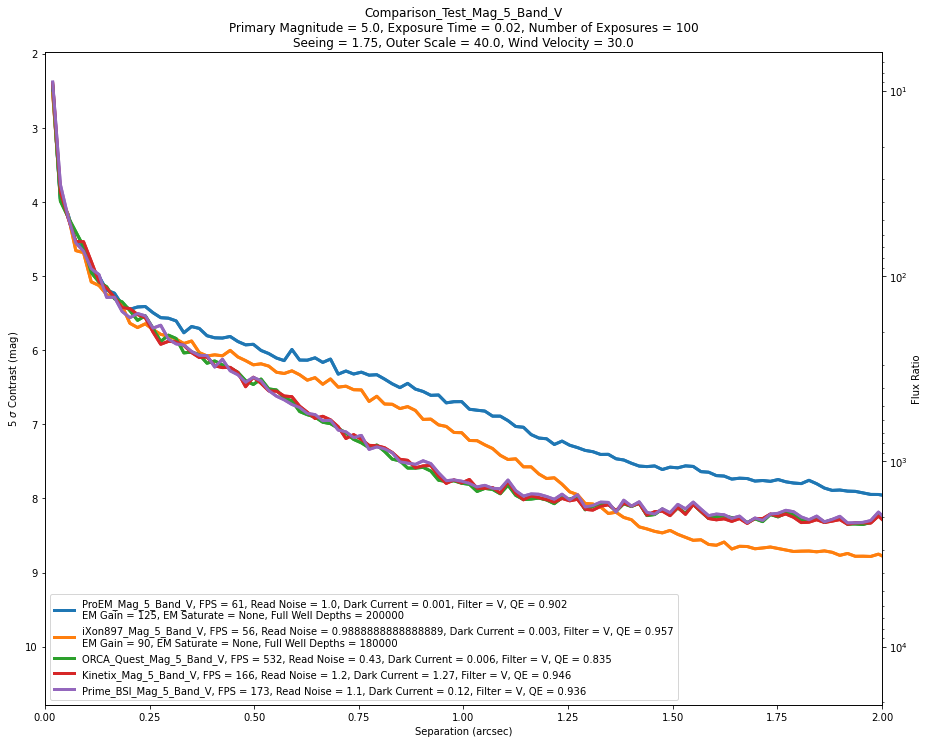

In [15]:
fig, ax1 = plt.subplots(figsize=(15,12))
for i in range(len(fits_files)):
    label = fits_files[i][0].header['Title'] + ", FPS = "+ fpss[i] + ", Read Noise = " + read_noises[i] + ", Dark Current = " + dark_currents[i] + ", Filter = " + filter_names[i] + ", QE = " + quantum_efficiencys[i]
    if EM_gains[i]:
        label = label + "\nEM Gain = " + EM_gains[i] + ", EM Saturate = " + EM_saturates[i] + ", Full Well Depths = " + full_well_depths[i]
    plt.plot(ACF_xaxs[i], ACF_ccs[i], label = label , lw=3)
title = "\nPrimary Magnitude = " + str(mags[0]) +  ", Exposure Time = " + exposure_times[0] + ", Number of Exposures = " + exposure_numbers[0] + "\nSeeing = " + seeings[0] + ", Outer Scale = " + outer_scales[0] + ", Wind Velocity = " + velocitys[0]
plt.xlim(0.0, 2.0)
ax1.set_xlabel(r'Separation (arcsec)')
ax1.set_ylabel(r'' + str(sigma) + ' $\sigma$ Contrast (mag)') 
ax1.tick_params(axis='y')
plt.gca().invert_yaxis()
plt.legend(loc='lower left')
ax2 = ax1.twinx() # second y-axis
for i in range(len(fits_files)):
    plt.plot(ACF_xaxs[i], 10**(0.4*ACF_ccs[i]) , lw=3)
ax2.set_ylabel('Flux Ratio')  
ax2.tick_params(axis='y')
plt.gca().invert_yaxis()
plt.yscale("log") 
plt.title(saved_file_name + title)
plt.savefig(saved_file_name + ".jpg", bbox_inches = 'tight',  dpi = 300)